<CatBoost에 범주형 인자 명시한 버전>

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import gc

# 데이터 불러오기 (인코딩 완료된 parquet 파일)
df = pd.read_parquet(data_root + "final_eda/train4_encoded.parquet")

# 라벨 인코딩 복원
le = LabelEncoder()
df['Segment'] = le.fit_transform(df['Segment'])  # 'A'~'E' -> 0~4

# 피처, 라벨 분리
drop_cols = ['Segment', 'ID', '기준년월'] if '기준년월' in df.columns else ['Segment', 'ID']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['Segment']

# 범주형 컬럼 추출 및 형변환
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    X[col] = X[col].astype('category')

# 메모리 정리
gc.collect()

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 50만 개 샘플링
sample_idx = np.random.choice(len(X_resampled), size=500_000, replace=False)
X_sampled = X_resampled.iloc[sample_idx].copy()
y_sampled = y_resampled.iloc[sample_idx].copy()

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

# 범주형 컬럼 형변환 (재확인)
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

# CatBoost 학습 및 평가
cat_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=cat_cols)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_val)

print("\n CatBoost Accuracy:", accuracy_score(y_val, cat_preds))
print("\n CatBoost Classification Report")
print(classification_report(y_val, cat_preds))

# XGBoost 학습 및 평가
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("\n XGBoost Accuracy:", accuracy_score(y_val, xgb_preds))
print("\n XGBoost Classification Report")
print(classification_report(y_val, xgb_preds))


🔹 CatBoost Accuracy: 0.82895

📋 CatBoost Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     19993
           1       0.99      1.00      1.00     20053
           2       0.72      0.61      0.66     19914
           3       0.63      0.64      0.64     20039
           4       0.82      0.90      0.86     20001

    accuracy                           0.83    100000
   macro avg       0.82      0.83      0.83    100000
weighted avg       0.82      0.83      0.83    100000



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:03:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔸 XGBoost Accuracy: 0.8322

📋 XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     19993
           1       1.00      1.00      1.00     20053
           2       0.72      0.62      0.67     19914
           3       0.64      0.64      0.64     20039
           4       0.82      0.91      0.86     20001

    accuracy                           0.83    100000
   macro avg       0.83      0.83      0.83    100000
weighted avg       0.83      0.83      0.83    100000



- 정확도와 세그먼트 C, D 클래스 예측력(F1-score) 모두 범주형 인자 명시 전이 더 나음.
- 범주형 인자 명시는 시도해볼 만한 옵션이므로, 교차 검증으로 판단하는 게 가장 정확함.

<범주형 인자 명시하지 않은 채 CatBoost 진행>

In [ ]:
# 필수 라이브러리 설치 및 임포트
!pip install pyarrow
!pip install -U imbalanced-learn
!pip install catboost xgboost

import pandas as pd
import numpy as np
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from google.colab import drive

In [ ]:
# Google Drive 마운트 및 경로 설정
from google.colab import drive
drive.mount('/content/drive')

data_root = '/content/drive/MyDrive/Colab Notebooks/final_project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

1. SMOTE 샘플링

In [ ]:
# 데이터 불러오기 및 SMOTE 샘플링
df = pd.read_parquet(data_root + "final_eda/train4_encoded.parquet")
df_sampled = df.sample(n=500_000, random_state=42)

# 불필요한 문자열 컬럼 제거
X = df_sampled.drop(columns=['Segment', 'ID', '기준년월'], errors='ignore')
y = df_sampled['Segment']

# SMOTE 샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_smote = pd.concat([X_resampled, y_resampled], axis=1)

# # 저장 (parquet으로, 경로는 원하면 드라이브로 변경 가능)
# df_smote.to_parquet(data_root + "final_sampling/train4_smote_500k.parquet", index=False)
# print("저장 완료: train4_smote_500k.parquet")

2. CatBoost 모델 학습 및 평가

In [ ]:
sample_idx = np.random.choice(len(X_resampled), size=500_000, replace=False)
X_sampled = X_resampled.iloc[sample_idx].reset_index(drop=True)
y_sampled = y_resampled.iloc[sample_idx].reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_val)

print("\n CatBoost Accuracy:", accuracy_score(y_val, cat_preds))
print("\n CatBoost Classification Report")
print(classification_report(y_val, cat_preds))


 CatBoost Accuracy: 0.84416

 CatBoost Classification Report
              precision    recall  f1-score   support

           A       0.98      1.00      0.99     19927
           B       1.00      1.00      1.00     19993
           C       0.75      0.66      0.70     20020
           D       0.65      0.65      0.65     20010
           E       0.83      0.91      0.87     20050

    accuracy                           0.84    100000
   macro avg       0.84      0.84      0.84    100000
weighted avg       0.84      0.84      0.84    100000



3. XGBoost 모델 학습 및 평가

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_sampled)
y_train_encoded, y_val_encoded = train_test_split(y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val = train_test_split(X_sampled, test_size=0.2, random_state=42, stratify=y_encoded)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_encoded)
xgb_preds = xgb_model.predict(X_val)

print("\n XGBoost Accuracy:", accuracy_score(y_val_encoded, xgb_preds))
print("\n XGBoost Classification Report")
print(classification_report(y_val_encoded, xgb_preds))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Accuracy: 0.84693

 XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19927
           1       1.00      1.00      1.00     19993
           2       0.75      0.67      0.71     20020
           3       0.65      0.65      0.65     20010
           4       0.83      0.92      0.87     20050

    accuracy                           0.85    100000
   macro avg       0.84      0.85      0.84    100000
weighted avg       0.84      0.85      0.84    100000



In [ ]:
# CatBoost 예측값도 숫자로 변환해 비교
cat_preds_encoded = le.transform(cat_preds)
print("\n CatBoost Classification Report (Encoded)")
print(classification_report(y_val_encoded, cat_preds_encoded))


 CatBoost Classification Report (Encoded)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19927
           1       1.00      1.00      1.00     19993
           2       0.75      0.66      0.70     20020
           3       0.65      0.65      0.65     20010
           4       0.83      0.91      0.87     20050

    accuracy                           0.84    100000
   macro avg       0.84      0.84      0.84    100000
weighted avg       0.84      0.84      0.84    100000



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


- 정확도(Accuracy)는 XGBoost 약간 더 우세(0.003 정도)
- 세그먼트별 F1-score: 세부 성능 비슷, 'C'에서만 XGBoost가 살짝 우위
- A, B는 거의 완벽히 예측했으나, C, D는 비교적 낮은 F1-score(모델이 헷갈려하는 클래스) -> 피처 분석/추출이나 클래스별 가중치 조정 필요

4. CatBoost 예측 결과 바탕으로 Confusion Matrix 시각화
- 어떤 클래스 잘 예측하고, 어떤 클래스에서 오차가 많은지 직관적 확인

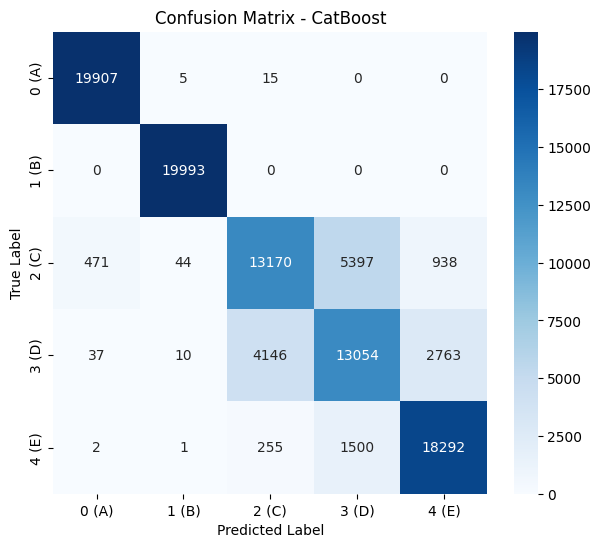

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix 계산
cm = confusion_matrix(y_val, cat_preds)

# 클래스 이름 정의 (숫자 레이블일 경우)
labels = ['0 (A)', '1 (B)', '2 (C)', '3 (D)', '4 (E)']

# 시각화
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CatBoost")
plt.show()

오분류
- 실제 C, 예측 D : 5397
- 실제 D, 예측 C : 4146
- 실제 D, 예측 E : 2763

세그먼트별 성능 요약
- C : D, E로 많이 헷갈림. C 분류 성능 낮음.
- D : D와 E,C 간 오분류 많음. 중간 세그먼트 간 구분 어려움.
- E : 잘 예측했으나 C/D로 일부 오분류
=> 피처 분리도가 낮거나 특성 겹치는 듯
- A, B : 모델이 잘 분류함. 그룹 특성이 명확할 수도.

5. XGBoost 예측 결과 바탕으로 Confusion Matrix 시각화

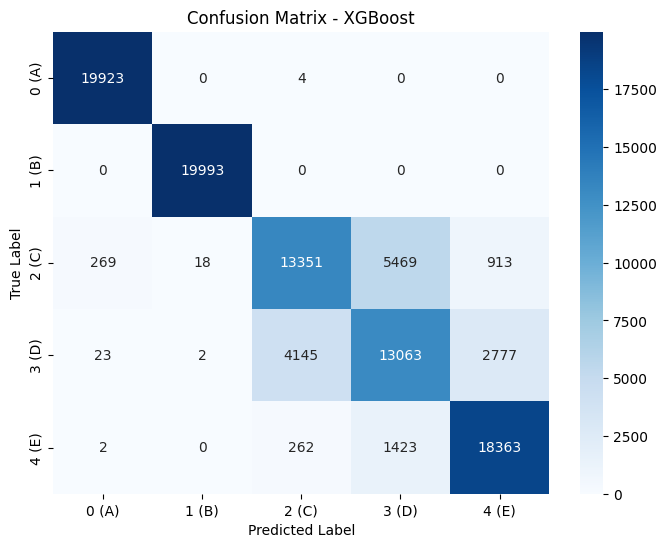

In [ ]:
# 혹시 y_val이 문자열이면 숫자로 변환
if y_val.dtype == 'object':
    y_val_encoded = le.transform(y_val)
else:
    y_val_encoded = y_val

# xgb_preds는 이미 숫자라고 가정
cm_xgb = confusion_matrix(y_val_encoded, xgb_preds)

# 시각화
labels = ['0 (A)', '1 (B)', '2 (C)', '3 (D)', '4 (E)']
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

- A, B는 거의 완벽 분류
- C, D, E는 서로 많이 헷갈림.

6. CatBoost 피처 중요도 시각화

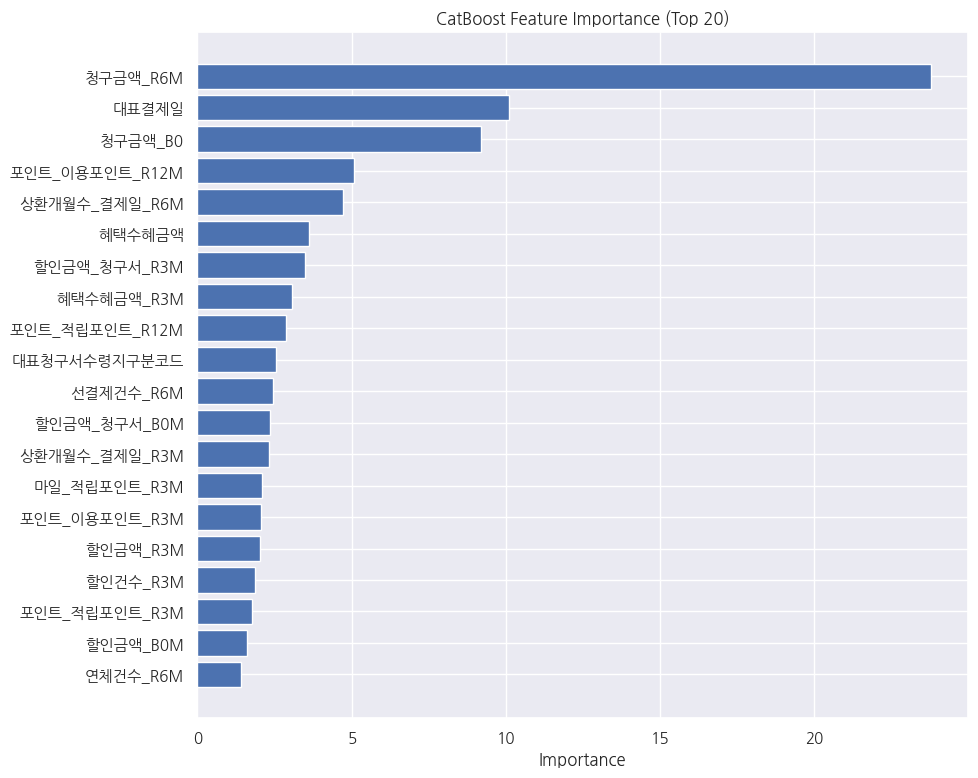

In [ ]:
import matplotlib.pyplot as plt

# 중요도 추출
cat_feature_importance = cat_model.get_feature_importance(prettified=True)

# 상위 20개 시각화
plt.figure(figsize=(10, 8))
plt.barh(cat_feature_importance['Feature Id'][:20][::-1],
         cat_feature_importance['Importances'][:20][::-1])
plt.title("CatBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

7. XGBoost 피처 중요도 시각화

<Figure size 1000x800 with 0 Axes>

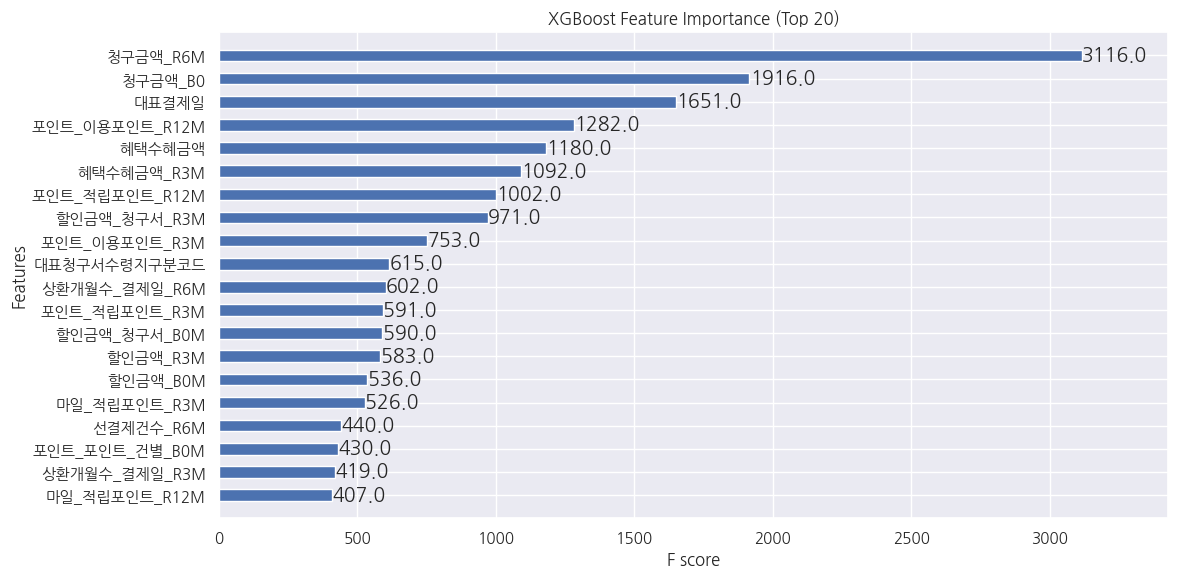

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# XGBoost 모델 중요도 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=20, height=0.5)
plt.title("XGBoost Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

두 모델 공통 중요 변수
- '청구금액_R6M', '대표결제일', '청구금액_B0', '포인트_이용포인트_R12M'

중요도가 너무 낮은 피처는 과감히 제거 후 모델 재학

8. 상위 N개 사용
: CatBoost와 XGBoost에서 공통으로 중요도가 높은 피처 Top N개만 선택하여 다시 학습

In [ ]:
# CatBoost와 XGBoost 중요도 불러오기
cat_importance = pd.Series(cat_model.feature_importances_, index=X.columns).sort_values(ascending=False)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# 상위 25개 피처에서 공통된 변수만 추출
top_n = 25
cat_top = set(cat_importance.head(top_n).index)
xgb_top = set(xgb_importance.head(top_n).index)
common_top_features = list(cat_top & xgb_top)

print("공통 Top 중요 변수:", common_top_features)


공통 Top 중요 변수: ['대표청구서수령지구분코드', '대표결제일', '포인트_적립포인트_R3M', '연체건수_R3M', '청구금액_R6M', '선결제건수_R6M', '할인건수_R3M', '선결제건수_R3M', '마일_잔여포인트_B0M', '포인트_마일리지_월적립_R3M', '포인트_이용포인트_R12M', '마일_적립포인트_R3M', '상환개월수_결제일_R6M', '할인금액_청구서_R3M', '할인금액_B0M', '할인금액_R3M', '청구금액_B0', '상환개월수_결제일_R3M', '포인트_이용포인트_R3M']


In [ ]:
# 중요 변수만 선택
X_reduced = X[common_top_features]

# 다시 train/test 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# 라벨 인코딩
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# CatBoost (문자형 레이블 사용 가능)
cat_model_reduced = CatBoostClassifier(verbose=0, random_state=42)
cat_model_reduced.fit(X_train, y_train)
cat_preds = cat_model_reduced.predict(X_val)
print("CatBoost Accuracy (Top Features):", accuracy_score(y_val, cat_preds))

# XGBoost (숫자형 레이블 필수)
xgb_model_reduced = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model_reduced.fit(X_train, y_train_enc)
xgb_preds = xgb_model_reduced.predict(X_val)
print("XGBoost Accuracy (Top Features):", accuracy_score(y_val_enc, xgb_preds))

# 상세 리포트
print("\nCatBoost Classification Report (Top Features)")
print(classification_report(y_val, cat_preds))

print("\nXGBoost Classification Report (Top Features)")
print(classification_report(y_val_enc, xgb_preds, target_names=le.classes_))


CatBoost Accuracy (Top Features): 0.84455


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:16:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (Top Features): 0.8433

CatBoost Classification Report (Top Features)
              precision    recall  f1-score   support

           A       0.67      0.10      0.17        42
           B       1.00      0.11      0.20         9
           C       0.60      0.38      0.46      5324
           D       0.54      0.38      0.45     14573
           E       0.89      0.96      0.92     80052

    accuracy                           0.84    100000
   macro avg       0.74      0.38      0.44    100000
weighted avg       0.82      0.84      0.83    100000


XGBoost Classification Report (Top Features)
              precision    recall  f1-score   support

           A       0.40      0.05      0.09        42
           B       1.00      0.11      0.20         9
           C       0.59      0.37      0.45      5324
           D       0.54      0.38      0.44     14573
           E       0.89      0.96      0.92     80052

    accuracy                           0.84    10000

9. Feature Importance 기반 제거
CatBoost, XGBoost에서 얻은 중요도 기준으로 너무 낮은 컬럼 제거

In [ ]:
# 중요도 DataFrame 생성
importances = pd.DataFrame({
    'feature': cat_model.feature_names_,
    'catboost_importance': cat_model.get_feature_importance(),
    'xgboost_importance': xgb_model.feature_importances_
})

# 평균 중요도 기준으로 정렬
importances['mean_importance'] = (importances['catboost_importance'] + importances['xgboost_importance']) / 2
low_importance = importances[importances['mean_importance'] < 0.01]['feature'].tolist()

# 중요도 낮은 피처 제거
X_reduced = X.drop(columns=low_importance)

10. vif 높은 컬럼 제거

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 수치형 피처만 추출
num_cols = X_reduced.select_dtypes(include=np.number).columns

# VIF 계산 함수
def calculate_vif(X):
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df.sort_values("VIF", ascending=False)

# VIF 확인
vif_df = calculate_vif(X_reduced[num_cols])
high_vif_cols = vif_df[vif_df['VIF'] > 10]['feature'].tolist()

# VIF 높은 컬럼 제거
X_final = X_reduced.drop(columns=high_vif_cols)

In [ ]:
# 최종 데이터 구성
# 라벨 y는 그대로 사용
y_final = y.copy()

# 다시 train/test 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y_final, test_size=0.2, stratify=y_final, random_state=42
)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_train, X_val, y_train, y_val, model_name=''):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"🔹 {model_name} Accuracy: {acc:.5f}")
    print(f"\n📋 {model_name} Classification Report")
    print(classification_report(y_val, preds))


In [ ]:
evaluate_model(model, X_train, X_val, y_train, y_val, model_name='catboost')

NameError: name 'model' is not defined

특정 세그먼트에서 구분력이 큰 컬럼 검토

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['청구서수령방법코드', '문제메세지수신여부', ...]:  # 낮은 중요도의 범주형 컬럼
    plt.figure(figsize=(6,3))
    sns.countplot(data=df, x=col, hue='Segment')
    plt.title(f"{col} vs Segment")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


ValueError: Could not interpret value `청구서수령방법코드` for `x`. An entry with this name does not appear in `data`.

<Figure size 600x300 with 0 Axes>

In [ ]:
from scipy.stats import chi2_contingency

for col in cat_cols:
    ct = pd.crosstab(df[col], df['Segment'])
    chi2, p, dof, expected = chi2_contingency(ct)
    if p < 0.05:
        print(f"{col} ⬅️ Segment와 연관 있음 (p={p:.4f})")


In [ ]:
# # Parquet로 저장
# df4.to_parquet("train_4번eda.parquet", index=False)

# # 파일 다운로드
# from google.colab import files
# files.download("train_4번eda.parquet")

##################

In [ ]:
# # parquet 파일 열기
# df1 = pd.read_parquet("201807_train_청구정보.parquet")

# # csv로 저장
# df1.to_csv("201807_train_청구정보.csv", index=False)


In [ ]:
# # CSV 파일 불러오기
# df = pd.read_csv('df_all.csv', encoding='cp949') # 경로는 필요 시 수정

# # Parquet 파일로 저장
# df.to_parquet('df_all.parquet', index=False)